# Project in SF2943
#### Playing around wtih the dataset~

In [313]:
#Imports
import numpy as np
import pandas as pd
import pylab as pb
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import acf, pacf as acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima_model import ARMA, ARIMA
import statsmodels.tsa.api as smt
from scipy.optimize import leastsq

In [2]:
#Read data as panda.DataFrame
pdData = pd.read_csv('data/Mauna_Loa_CO2_monthly_mean_data.csv',
                     sep=',',header=None);
pdDataYearly = pd.read_csv('data/Mauna_Loa_CO2_yearly_mean_data.csv',
                           sep='   ',header=0,engine='python');

removeYears = 0;

#clean Data, remove first and last year.
pdData.drop(pdData.index[[718,719,720]],inplace=True)
pdData.drop(pdData.index[np.arange(10 + removeYears*12)],inplace=True)
pdDataYearly.drop(pdDataYearly.index[np.arange(removeYears)],inplace=True)

#Also save as numpy array
npData = pdData.as_matrix();
npDataYearly = pdDataYearly.as_matrix();

## Visualize data and remove trends/cycles

###### Raw data with mean, trend removed etc.

###### Residuals after polyfit, 2nd and 3rd degree polynomials

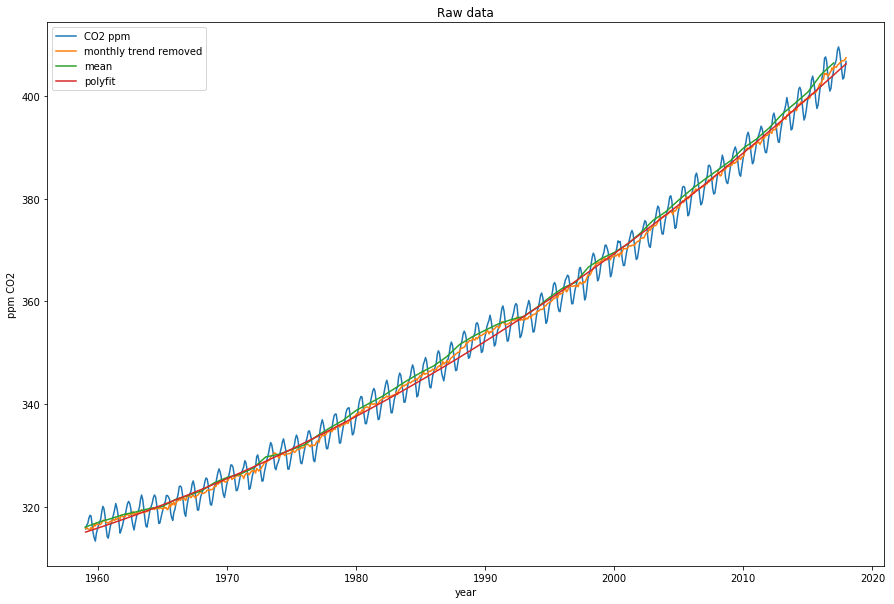



Seems like a polynomial fit or removing yearly average might be the best approaches.




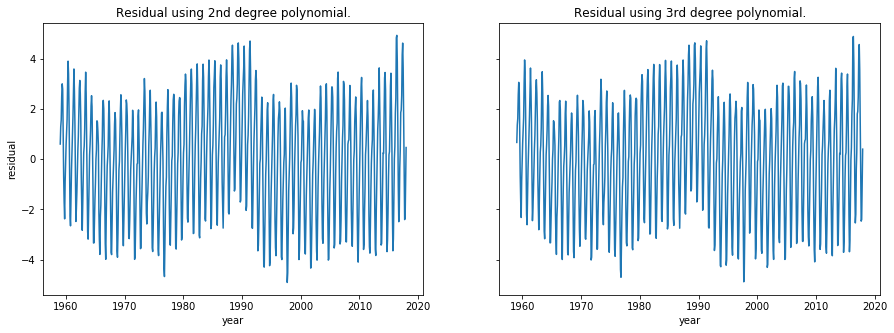

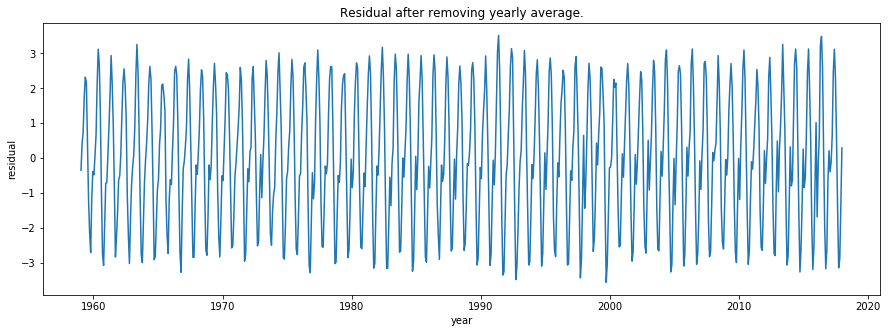


Sum of residuals: 2nd deg. poly: 1323.0, yearly mean: 1107.0

As we can see, removing the yearly average is slight better thanfitting the polynomial.




In [3]:
#-----Visualize raw data stuff-----
pb.close()
fig, ax = pb.subplots(1,1,figsize=(15,10));

#Plot raw data
pdData.plot(x=2,y=4,ax=ax,label="CO2 ppm")

#Plot raw data with monthly trend removed (already done in the csv file)
pdData.plot(x=2,y=5,ax=ax,label="monthly trend removed")

#Plot yearly average
pdDataYearly.plot(x='year',y='mean',ax=ax,label="mean")

#Fit polynomial to data
p2 = np.polyfit(x=pdData[2],y=pdData[4],deg=2)
p3 = np.polyfit(x=pdData[2],y=pdData[4],deg=3)
poly2 = np.poly1d(p2);
poly3 = np.poly1d(p3);
pb.plot(pdData[2],poly2(pdData[2]),label="polyfit")

pb.legend()
pb.title("Raw data")
pb.ylabel("ppm CO2")
pb.show()
print("\n\nSeems like a polynomial fit or removing yearly average might "
      "be the best approaches.\n\n")


#-----Visualize residuals-----
fig2, ax2 = pb.subplots(1,2,figsize=(15,5),sharey=True)
ax2[0].plot(pdData[2],pdData[4]-poly2(pdData[2]))
ax2[0].set_title("Residual using 2nd degree polynomial.")
ax2[1].plot(pdData[2],pdData[4]-poly3(pdData[2]))
ax2[1].set_title("Residual using 3rd degree polynomial.")
ax2[0].set_ylabel("residual")
ax2[0].set_xlabel('year')
ax2[1].set_xlabel('year')


#Plot yearly mean vector, using year not month average
yearly_mean = np.ones((12,len(pdDataYearly)));
yearly_mean = (yearly_mean*(pdDataYearly['mean'].values.reshape(1,-1))).T.ravel();
yearly_mean_poly = poly2(pdData[2]);
fig3, ax3 = pb.subplots(1,1,figsize=(15,5));
ax3.plot(pdData[2],pdData[4]-yearly_mean);
ax3.set_title("Residual after removing yearly average.")
ax3.set_ylabel("residual")
ax3.set_xlabel('year')
pb.show();

res2poly = np.sum(np.abs(pdData[4]-poly2(pdData[2])));
resYearlyAvg = np.sum(np.abs(pdData[4]-yearly_mean));

print("\nSum of residuals: 2nd deg. poly: {}, yearly mean: {}"
      "\n\nAs we can see, removing the yearly average is slight better than"
      "fitting the polynomial.\n\n".format(round(res2poly),round(resYearlyAvg)))

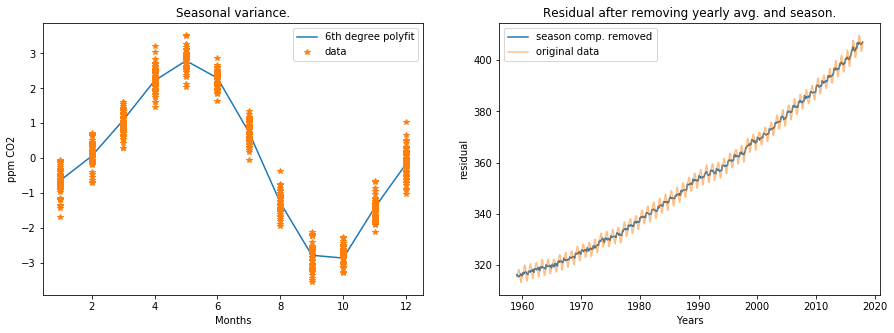


There definitely is a seasonal component in this time series,
and it gets better if we remove the yearly one.




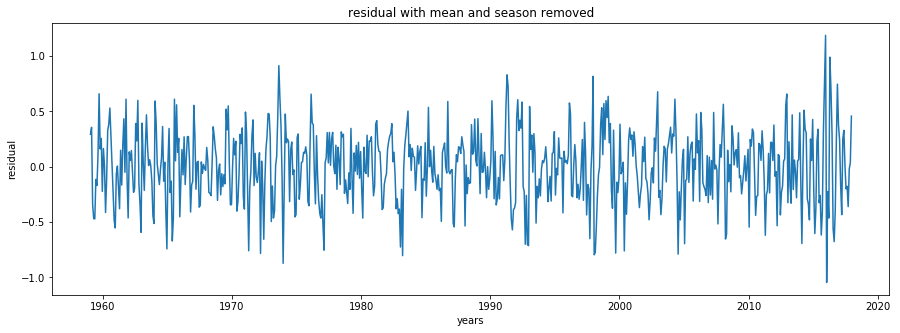


The residual now seems to be more random than before,the cyclic component is removed,
 but there stillseems to be some other underlying cyclic component,
the peaks of the residual still seems somewhat cyclic.


In [4]:
#-----Removing seasonal component using 4th degree polynomial-----
p_season = np.polyfit(pdData[1],pdData[4]-yearly_mean,deg=6)
poly_season = np.poly1d(p_season);
fig4, ax4 = pb.subplots(1,2,figsize=(15,5));
ax4[0].plot(range(1,13),poly_season(range(1,13)),label="6th degree polyfit")
ax4[0].plot(pdData[1],pdData[4]-yearly_mean,'*',label="data")
ax4[0].set_title("Seasonal variance.")
ax4[0].set_xlabel("Months")
ax4[0].set_ylabel("ppm CO2")

ax4[1].plot(pdData[2],pdData[4]-poly_season(pdData[1]),label="season comp. removed")
ax4[1].plot(pdData[2],pdData[4],alpha=0.5,label="original data")
ax4[1].set_title("Residual after removing yearly avg. and season.")
ax4[1].set_xlabel("Years")
ax4[1].set_ylabel("residual")
ax4[0].legend()
ax4[1].legend()
pb.show()

print("\nThere definitely is a seasonal component in this time series,"
      "\nand it gets better if we remove the yearly one.\n\n")

fig5, ax5 = pb.subplots(1,1,figsize=(15,5));
ax5.plot(pdData[2],pdData[4]-yearly_mean-poly_season(pdData[1]))
ax5.set_title("residual with mean and season removed")
ax5.set_xlabel("years")
ax5.set_ylabel("residual")
pb.show()

print("\nThe residual now seems to be more random than before,"
      "the cyclic component is removed,\n but there still"
      "seems to be some other underlying cyclic component,\n"
      "the peaks of the residual still seems somewhat cyclic.")

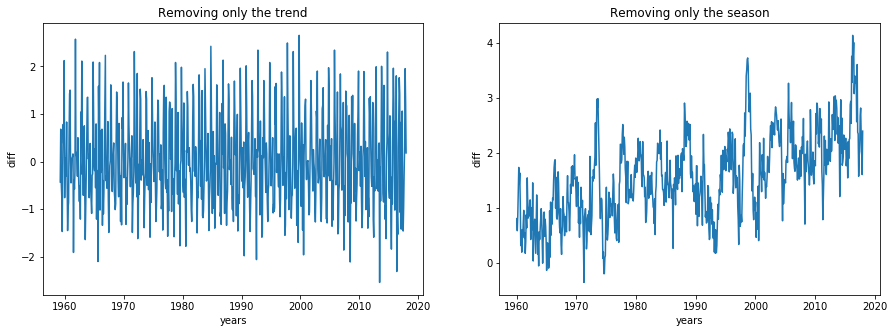

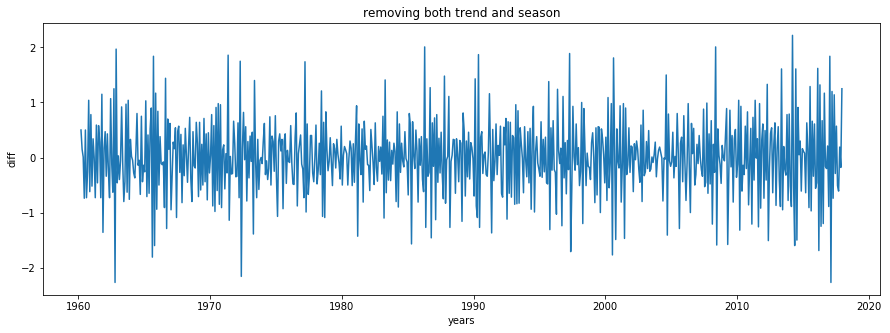



There still seems to be some cyclic component left, although it's much better.


In [5]:
#-----Removing seasonal component and trend using differencing-----
fig, ax = pb.subplots(1,2,figsize=(15,5));
ax[0].plot(pdData[2],pdData[4].diff(1).diff(1))
ax[1].plot(pdData[2],pdData[4].diff(12))
ax[0].set_title("Removing only the trend")
ax[1].set_title("Removing only the season")
ax[0].set_ylabel("diff")
ax[1].set_ylabel("diff")
ax[0].set_xlabel("years")
ax[1].set_xlabel("years")
pb.show()

fig, ax = pb.subplots(1,1,figsize=(15,5));
ax.plot(pdData[2],pdData[4].diff(12).diff(1).diff(1))
ax.set_title("removing both trend and season")
ax.set_ylabel("diff")
ax.set_xlabel("years")
pb.show()

print("\n\nThere still seems to be some cyclic component left,"
      " although it's much better.")

## Look at PACF and ACF

##### Not sure if I did this right..

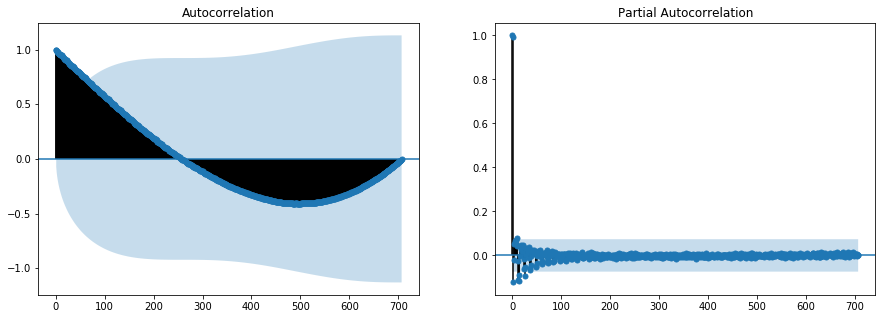



If I understand correctly we can see that the ACR is decaying
geometrically and the PACF is significant for only a few certain
values. This means that the ts can me modeled as an AR process in
the absence of differing. We can see below that the PACF is significant
for values that are multiples of 12, that it seems to be seasonal
with period 12 (as we discovered earlier). It is also very significant
for h = 1, so we should atleast have q = 1.


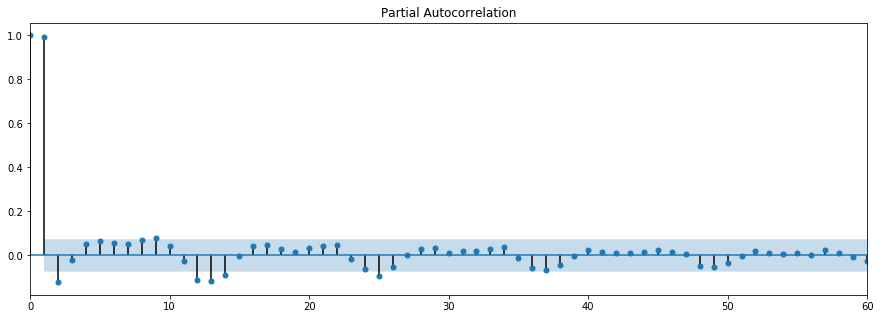

In [6]:
pb.close()
fig, ax = pb.subplots(1,2,figsize=(15,5))
plot_acf(pdData[4],ax=ax[0])
plot_pacf(pdData[4],ax=ax[1])
pb.show()

print("\n\nIf I understand correctly we can see that the ACR is decaying\n"
      "geometrically and the PACF is significant for only a few certain\n"
      "values. This means that the ts can me modeled as an AR process in\n"
      "the absence of differing. We can see below that the PACF is significant\n"
      "for values that are multiples of 12, that it seems to be seasonal\n"
      "with period 12 (as we discovered earlier). It is also very significant\n"
      "for h = 1, so we should atleast have q = 1.")

fig2, ax2 = pb.subplots(1,1,figsize=(15,5))
plot_pacf(pdData[4],ax=ax2)
ax2.set_xlim(0,60)
pb.show()

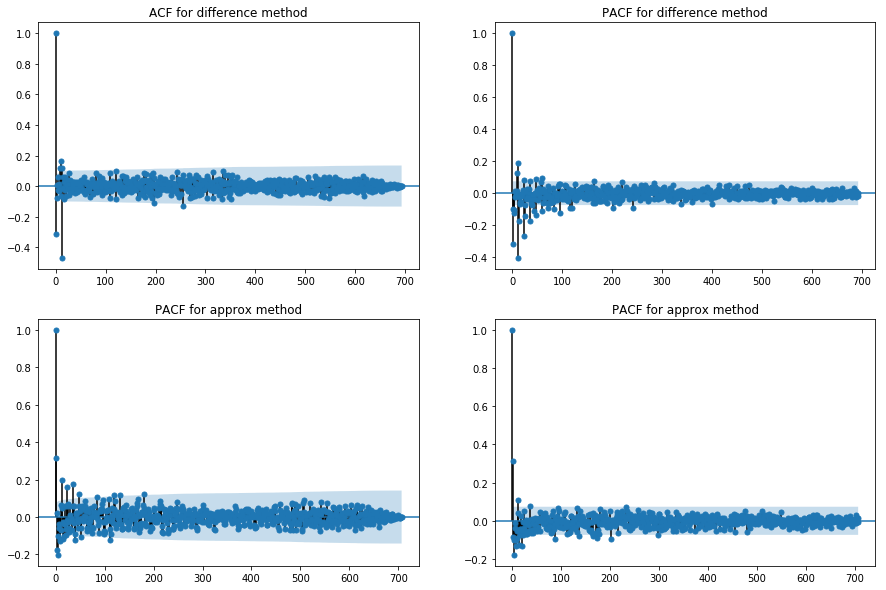

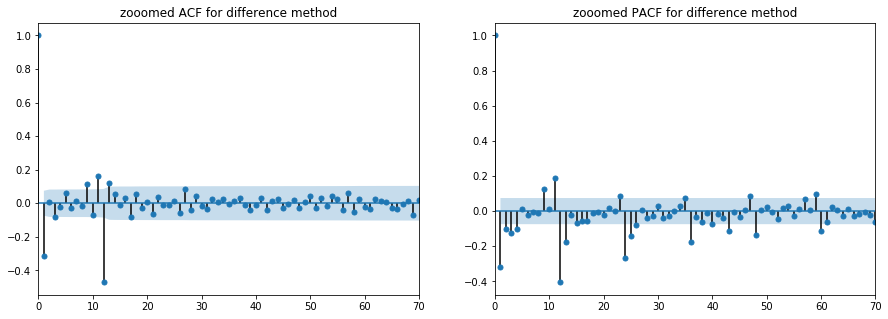

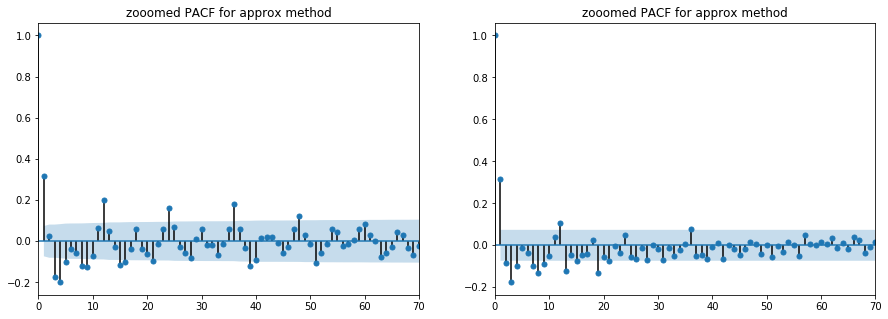

In [7]:
pb.close()
X = pdData[4].diff(12).diff(1)
X2 = pdData[4]-yearly_mean-poly_season(pdData[1])
#X3 = (pdData[4]-yearly_mean-poly_season(pdData[1])).diff(17)
fig, ax = pb.subplots(2,2,figsize=(15,10))

plot_acf(X[14:].as_matrix(),ax=ax[0,0],title="ACF for difference method")
plot_pacf(X[14:].as_matrix(),ax=ax[0,1],title="PACF for difference method")
plot_acf(X2.as_matrix(),ax=ax[1,0],title="PACF for approx method")
plot_pacf(X2.as_matrix(),ax=ax[1,1],title="PACF for approx method")
#plot_acf(X3[17:].as_matrix(),ax=ax[2,0])
#plot_pacf(X3[17:].as_matrix(),ax=ax[2,1])
pb.show()

fig2, ax2 = pb.subplots(1,2,figsize=(15,5))
plot_acf(X[14:],ax=ax2[0],title="zooomed ACF for difference method")
plot_pacf(X[14:],ax=ax2[1],title="zooomed PACF for difference method")
ax2[0].set_xlim(0,70)
ax2[1].set_xlim(0,70)
pb.show()

fig2, ax2 = pb.subplots(1,2,figsize=(15,5))
plot_acf(X2.as_matrix(),ax=ax2[0],title="zooomed PACF for approx method")
plot_pacf(X2.as_matrix(),ax=ax2[1],title="zooomed PACF for approx method")
ax2[0].set_xlim(0,70)
ax2[1].set_xlim(0,70)
pb.show()

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  694
Model:                    ARMA(1, 13)   Log Likelihood                -171.189
Method:                           css   S.D. of innovations              0.310
Date:                Wed, 18 Apr 2018   AIC                            372.377
Time:                        10:34:11   BIC                            440.493
Sample:                             1   HQIC                           398.720
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.1321      0.101      1.309      0.191      -0.066       0.330
ma.L1.y       -0.5105      0.091     -5.588      0.000      -0.690      -0.331
ma.L2.y        0.0077      0.026      0.292      0.7

C:\Users\lucas_000\Anaconda3\envs\ML\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


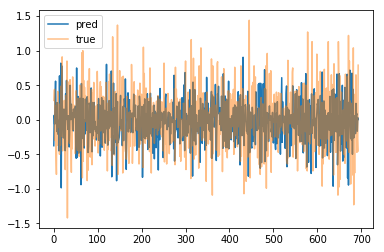

In [87]:
shift = 14;
max_lag = 1
mdl = smt.ARMA((X[shift:]).as_matrix(), order=(1,13)).fit(
    maxlag=max_lag, method='css', trend='nc')

print(mdl.summary())

prediction = mdl.predict(start=shift,end=len(X)-1)
pb.plot(prediction,label="pred")
pb.plot((X[shift:]).as_matrix(),label="true",alpha=0.5)
pb.legend()
pb.show()

## Doing all of the above using libraries

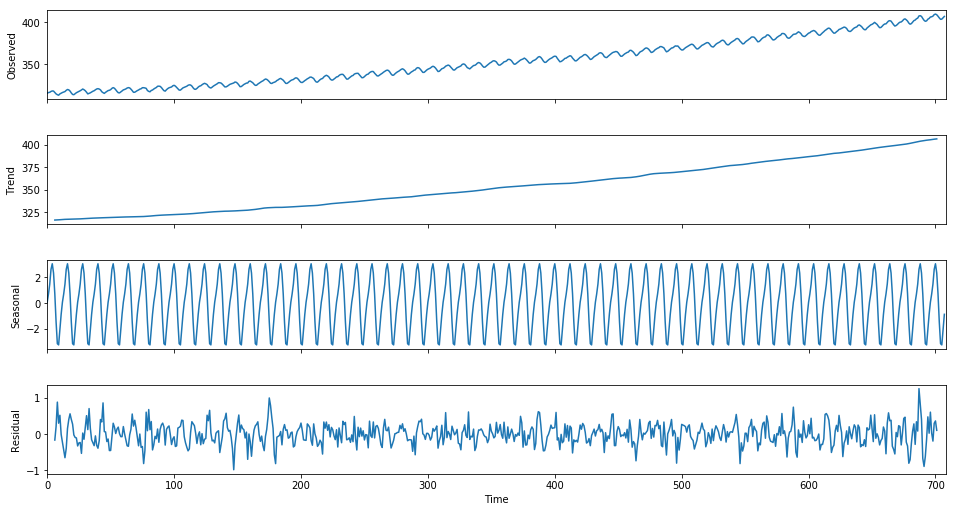

In [9]:
#Create a trend, seasonal decomposition and residual using statsmodels
decomp = smt.seasonal_decompose(pdData[4].as_matrix(),freq=12)

fig = pb.figure()  
fig = decomp.plot()  
fig.set_size_inches(15, 8)
pb.show()

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

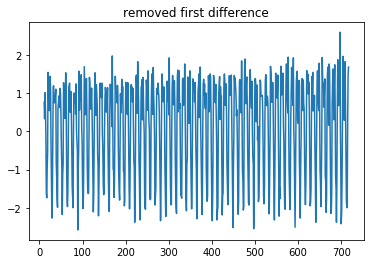

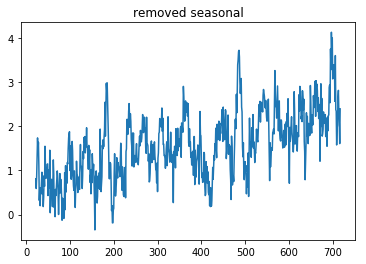

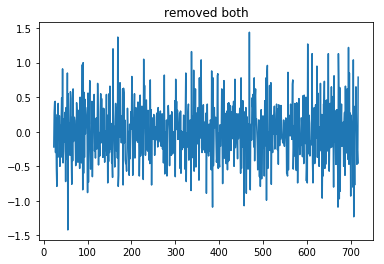

ADF Statistic: -3.722618
p-value: 0.003806
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [381]:
#Basically the same as before when we used diff()
first_diff = pdData[4]-pdData[4].shift(1)
pb.plot(first_diff)
pb.title("removed first difference")
pb.show()

seasonal_diff = pdData[4]-pdData[4].shift(12)
pb.plot(seasonal_diff)
pb.title("removed seasonal")
pb.show()

true_diff = first_diff-first_diff.shift(12)
pb.plot(true_diff)
pb.title("removed both")
pb.show()

result = adfuller(seasonal_diff[12:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

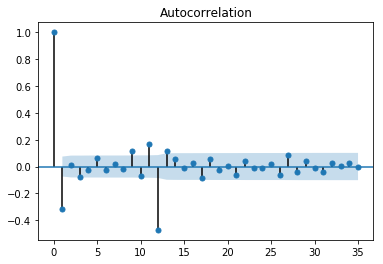

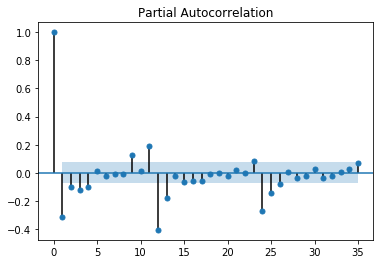



I asked the professor about these plots and she thought
they looked a bit wierd, but ok.


In [382]:
#Plot ACF and PACF for the above, same as before
plot_acf(true_diff[13:],lags=35)
pb.show()
plot_pacf(true_diff[13:],lags=35)
pb.show()

print("\n\nI asked the professor about these plots and she thought\n"
      "they looked a bit wierd, but ok.")

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  708
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -171.892
Date:                            Wed, 18 Apr 2018   AIC                            353.784
Time:                                    15:56:02   BIC                            376.596
Sample:                                         0   HQIC                           362.597
                                            - 708                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1874      0.084      2.225      0.026       0.022       0.353
ma.L1         -0.5509      0.073   

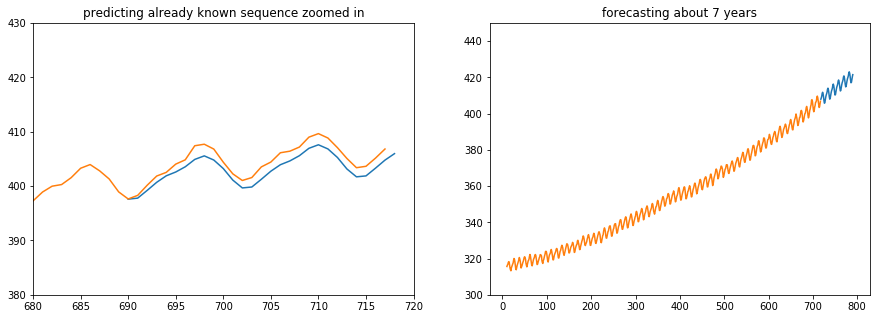

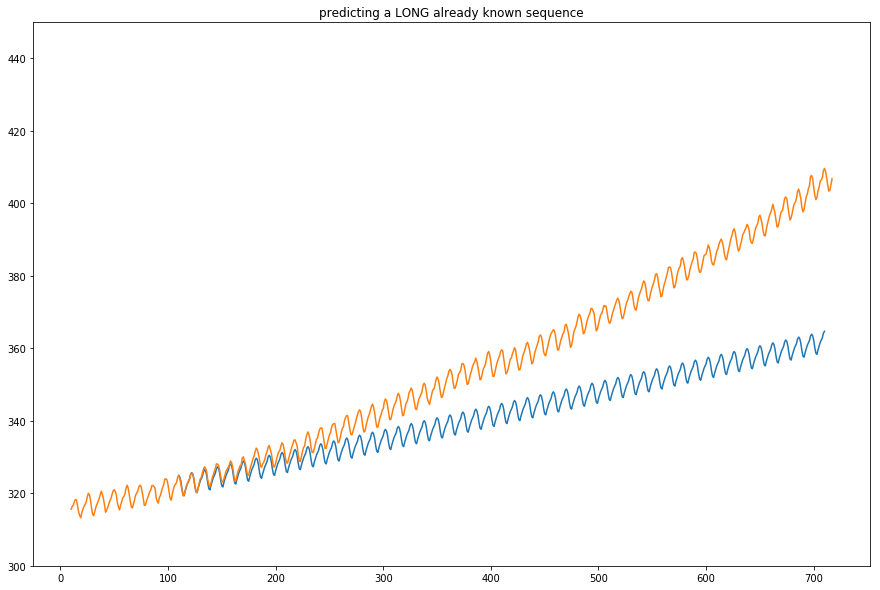

In [494]:
#Using a sarimax model to remove trend and seasonal component
#I have not spent a lot of time optimizing these parameters.
mod = smt.statespace.SARIMAX(pdData[4].as_matrix(), trend='n',
                             order=(1,1,1), seasonal_order=(1,1,1,12))
results = mod.fit()
print(results.summary())
fig, ax = pb.subplots(1,2,figsize=(15,5))
pred = results.predict(start = 680, end= 708, dynamic= True)  
ax[0].plot(np.arange(690,719),pred)
ax[0].plot(pdData[4])
ax[0].set_xlim(680,720)
ax[0].set_ylim(380,430)
ax[0].set_title("predicting already known sequence zoomed in")

pred = results.predict(start = 708, end= 780, dynamic= True)  
ax[1].plot(np.arange(718,791),pred)
ax[1].plot(pdData[4])
ax[1].set_ylim(300,450)
ax[1].set_title("forecasting about 7 years")

fig, ax = pb.subplots(1,1,figsize=(15,10))
pred = results.predict(start = 100, end= 700, dynamic= True)  
ax.plot(np.arange(110,711),pred)
ax.plot(pdData[4])
ax.set_ylim(300,450)
ax.set_title("predicting a LONG already known sequence")


pb.show()

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  600
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 12)   Log Likelihood                -140.752
Date:                            Wed, 18 Apr 2018   AIC                            291.504
Time:                                    18:49:04   BIC                            313.488
Sample:                                         0   HQIC                           300.062
                                            - 600                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3044      0.038     -7.977      0.000      -0.379      -0.230
ma.L1         -0.9998      0.343   

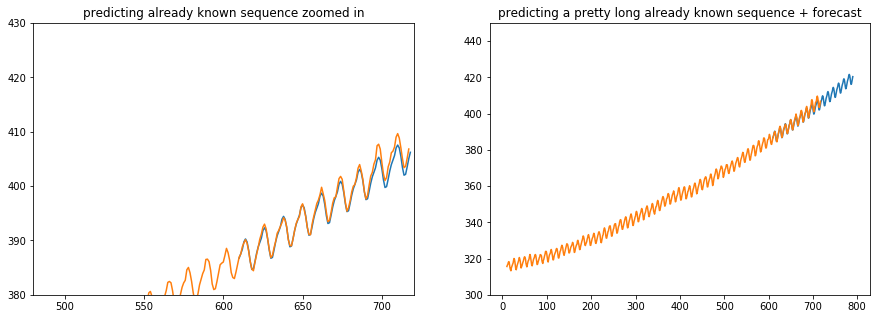

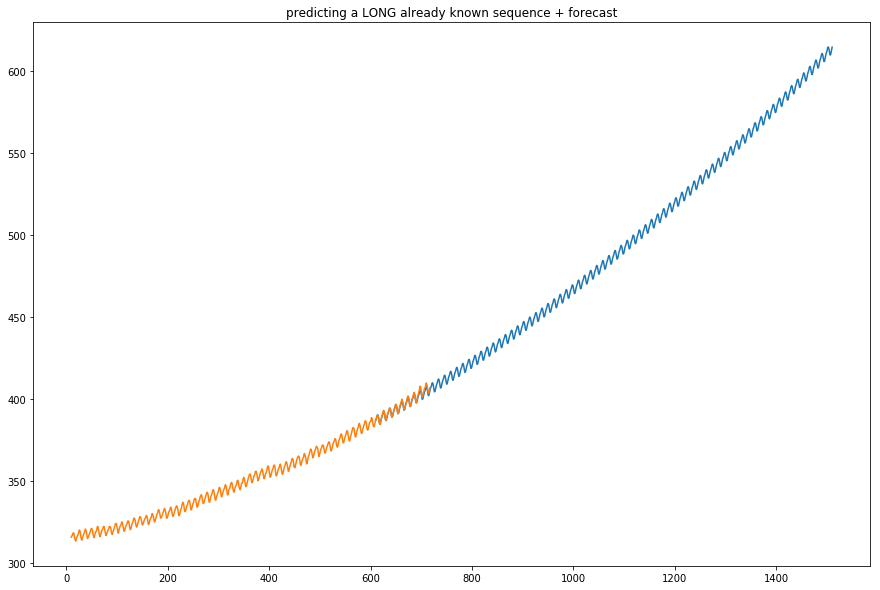

In [505]:
#Using a sarimax model to remove trend and seasonal component
#I have not spent a lot of time optimizing these parameters.
#Split intro train / test
#Did some testing and a ARMIA model with (4,2,1) together with a seasonal
#component of 12 months seems to be the best fit, so far atleast.
train = pdData[4].as_matrix()[:600];
#test = pdData[4].as_matrix()[600:];
mod = smt.statespace.SARIMAX(train, trend='n',
                             order=(1,2,1), seasonal_order=(1,1,1,12))
results = mod.fit()
print(results.summary())
fig, ax = pb.subplots(1,2,figsize=(15,5))
pred = results.predict(start = 600, end= 708,dynamic=True)  
ax[0].plot(np.arange(610,719),pred)
ax[0].plot(pdData[4])
ax[0].set_xlim(480,720)
ax[0].set_ylim(380,430)
ax[0].set_title("predicting already known sequence zoomed in")

pred = results.predict(start = 600, end= 780,dynamic=True)  
ax[1].plot(np.arange(610,791),pred)
ax[1].plot(pdData[4])
ax[1].set_ylim(300,450)
ax[1].set_title("predicting a pretty long already known sequence + forecast")

fig, ax = pb.subplots(1,1,figsize=(15,10))
pred = results.predict(start = 600, end= 1500,dynamic=True)  
ax.plot(np.arange(610,1511),pred)
ax.plot(pdData[4])
ax.set_title("predicting a LONG already known sequence + forecast")


pb.show()

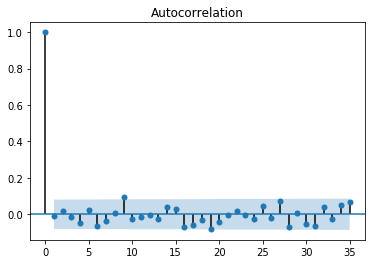

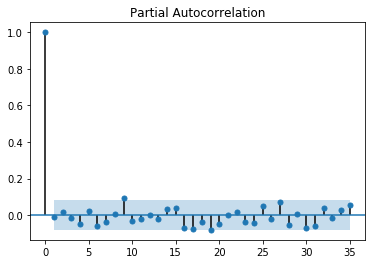

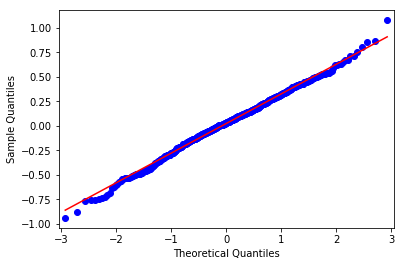

In [504]:
#residual is only white noise after 14 datapoints, maybe cuz of us doing seasonal stuff, and differenciating=
pb.close()
res = results.resid[14:];
plot_acf(res,lags=35)
plot_pacf(res,lags=35)
qqplot(res,line='s')
pb.show()


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  694
Model:                    ARMA(12, 1)   Log Likelihood                -256.498
Method:                       css-mle   S.D. of innovations              0.349
Date:                Wed, 18 Apr 2018   AIC                            542.995
Time:                        13:48:37   BIC                            611.132
Sample:                             0   HQIC                           569.345
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.005      0.444      0.657      -0.008       0.013
ar.L1.y        0.0657      0.067      0.976      0.329      -0.066       0.198
ar.L2.y       -0.0103      0.040     -0.259      0.7

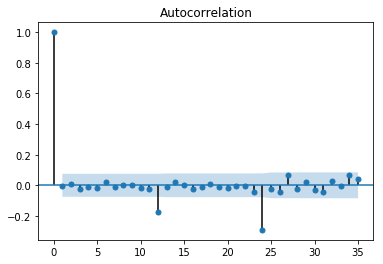

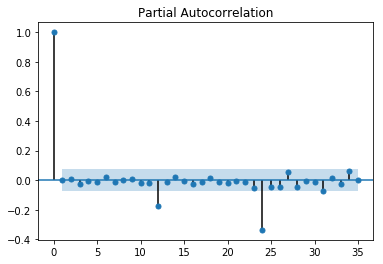

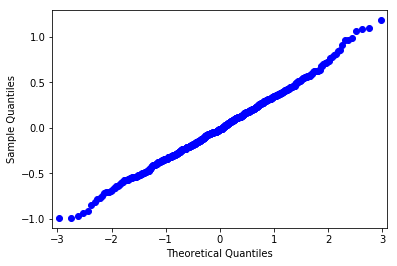

In [493]:
#Using a sarimax model to remove trend and seasonal component
#I have not spent a lot of time optimizing these parameters.
mod = ARIMA(true_diff.as_matrix()[14:],order=(12,0,1))
results = mod.fit()
print(results.summary())
res = results.resid[14:];
plot_acf(res,lags=35)
plot_pacf(res,lags=35)
qqplot(res)
pb.show()